## Geo-Vec Model 
- basic geo-vec model
- auxilliary task models

#### Imports:

In [2]:
import numpy as np
import pandas as pd
import scipy.sparse as ss

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#### Helper Functions

In [96]:
class Doc2Graph():
    """Convert tokenized document to weighted Adjacency matrix
    and graph Laplacian"""
    def __init__(self, doc, doc_id):
        self.doc = doc
        self.doc_id = doc_id
        
    def doc2graph(self):
        g = self.load(self.doc_id)
            
        if not g:
            As = self.get_A(self.doc)
            Ls = self.get_L(As)
            g = As.append(Ls)
            self.save(g)
        
        return g
    
    def get_As(self):
        """Get the weighted adjacency matrices of incoming
        and outcoming edges"""
        
        pass
    
    def get_L(self, As, renorm_trick=False):
        """Create graph Laplacians from adjacency matrices"""
        Ls = []
        for A in As:
            A = sp.coo_matrix(A)
            if renorm_trick:
                A += sp.eye(A.shape[0])
            D_inv_sqrt = sp.diags(np.power(np.array(A.sum(1)), -0.5).flatten())
            L = A.dot(D_inv_sqrt).transpose().dot(D_inv_sqrt).tocoo()
            Ls.append(L)
            
        return Ls
    
    def save(self, g):
        """Save graph to folder for reuse"""
        pass
    
    def load(self):
        pass
            
def sparse_to_tuple(sparse_mx):
    if not ss.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def sp2tf(sp_t):
    t = sparse_to_tuple(sp_t)
#     tensor = tf.SparseTensor(t[0],t[1].astype(np.float32),t[2])
    tensor = tf.SparseTensorValue(t[0],t[1].astype(np.float32),t[2])
    return tensor

def dropout_sparse(x, keep_prob, num_nonzero_elems):
    """Dropout for sparse tensors. Currently fails for very large sparse tensors (>1M elements)
    """
    noise_shape = [num_nonzero_elems]
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1./keep_prob)

#### Geo-Vec

In [114]:
class GeoVec():
    def __init__(self, corpus=None, vocab_size=10, h_layers = [8, 4], 
                 act = tf.nn.relu, dropout=0.0, learning_rate = 1e-3):
        """Geo-Vec model as described in the report model section."""
        
        self.corpus = corpus
        self.vocab_size = vocab_size
        self.h_layers = h_layers
        self.act = act
        self.dropout = dropout
        self.learning_rate = learning_rate
        
        # use for plotting
        self._loss_vals, self._acc_vals = [], []
        
        #placeholders
        s = [self.vocab_size, self.vocab_size]
        self.placeholders = {
            'A_o': tf.sparse_placeholder(tf.float32),
            'L_o': tf.sparse_placeholder(tf.float32),
            'A_i': tf.sparse_placeholder(tf.float32),
            'L_i': tf.sparse_placeholder(tf.float32),
            'dropout': tf.placeholder_with_default(0., shape=())
        }
        
        # model
        self.aux_losses = None
        dummy = sp2tf(ss.eye(self.vocab_size))
        self.init_model(x=dummy)

        #optimizer
        self.init_optimizer()
        
        #sess
        self.trained = 0
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def init_model(self, x, aux_tasks = None):
        """geo-vec model with variable number of gcn layers. Optional aux_taks
        param is now unimplemented to specify which tasks to add. All aux losses
        should be gathered in a self.aux_losses variable to gather later on."""
        for i, h_layer in enumerate(self.h_layers):
            if i == 0:
                h = self.gcn(x, self.vocab_size, self.h_layers[0], self.act, layer=i,sparse=True)  
            elif (i+1) < len(self.h_layers):
                h = self.gcn(h, self.h_layers[i-1], h_layer, self.act, layer=i, )
            else:
                self.emb_o, self.emb_i = self.gcn(h, self.h_layers[i-1], 
                                             h_layer, act=lambda x: x, layer=i,separate=True)
        
        # here we can left multiply the last layer h
        # and perform auxilliary tasks.
        
        self.recon_o = self.decode(self.emb_o)
        self.recon_i = self.decode(self.emb_i)
    
    def gcn(self, x, dim_in, dim_out, act, layer, sparse=False, separate=False):
        """basic graph convolution using a split up adjacency matrix.
        The separation param is to create the final embeddings to reconstruct."""
        w1 = tf.get_variable('w1_{}'.format(layer), shape=[dim_in, dim_out], 
                             initializer=tf.contrib.layers.xavier_initializer())
        w2 = tf.get_variable('w2_{}'.format(layer), shape=[dim_in, dim_out], 
                             initializer=tf.contrib.layers.xavier_initializer())

        if sparse:
            x1 = tf.sparse_tensor_dense_matmul(x, w1)
            x2 = tf.sparse_tensor_dense_matmul(x, w2)
        else:
            x1 = tf.matmul(x, w1)
            x2 = tf.matmul(x, w2)
            
        x1 = tf.sparse_tensor_dense_matmul(self.placeholders['L_o'], x1)
        x2 = tf.sparse_tensor_dense_matmul(self.placeholders['L_i'], x2)
        
        if separate:
            return self.act(x1), self.act(x2)
        
        return self.act(x1 + x2)
    
    def decode(self, x, cap = 1000):
        """simple innerproduct decoder with sigmoid activation to scale
        the edged between 0-1000 (assuming more co-occurances are unlikely)."""
        x = tf.nn.dropout(x, 1-self.dropout)
        x = tf.reshape(tf.matmul(x, tf.transpose(x)), [-1])
        return tf.sigmoid(x)*cap
        
    def init_optimizer(self):
        """initializes optimizer and computes loss + accuracy. The loss function
        is currently a MSE, due to the fact we are dealing with weighted edges.
        This does not seem ideal, and should be thought about."""
        
        labels_o = tf.reshape(tf.sparse_tensor_to_dense(
                                self.placeholders['A_o'],validate_indices=False), [-1])
        labels_i = tf.reshape(tf.sparse_tensor_to_dense(
                                self.placeholders['A_i'],validate_indices=False), [-1])
        loss_o = tf.losses.mean_squared_error(self.recon_o, labels_o)
        loss_i = tf.losses.mean_squared_error(self.recon_i, labels_i) 
        self.loss = loss_o + loss_i
        
        # gather aux losses and add to total loss
        if self.aux_losses:
            self.loss += self.aux_losses
        
        # optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.opt_op = optimizer.minimize(self.loss)

        cp_o = tf.equal(tf.cast(tf.greater_equal(self.recon_o, 0.5), tf.int32),
                                                   tf.cast(labels_o, tf.int32))
        cp_i = tf.equal(tf.cast(tf.greater_equal(self.recon_i, 0.5), tf.int32),
                                                   tf.cast(labels_i, tf.int32))
        correct_prediction = tf.concat([cp_o, cp_i], 0)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def get_feed_dict(self, A_o, A_i, L_o, L_i):
        feed_dict = {self.placeholders['A_o']: A_o,
                     self.placeholders['A_i']: A_i,
                     self.placeholders['L_o']: L_o,
                     self.placeholders['L_i']: L_i}
        return feed_dict
    
    def get_sample(self):
        """get random sample from corpus graph cache"""
        dummy = [] 
        for i in range(4):
            dummy.append(sp2tf(ss.eye(self.vocab_size)))

        return dummy
    
    def train(self, num_epochs = 100, print_freq=50):
        """train op that can be invoked multiple times."""
        tf.set_random_seed(42)
        np.random.seed(42)

        for e in range(num_epochs):
            self.trained += 1
            A_o, A_i, L_o, L_i = self.get_sample()
            feed_dict = self.get_feed_dict(A_o, A_i, L_o, L_i)
    
            outs = self.sess.run([self.opt_op, self.loss, self.accuracy], feed_dict=feed_dict)
            avg_loss, avg_acc = outs[1], outs[2]
            self._loss_vals.append(avg_loss)
            self._acc_vals.append(avg_acc)
            
            print('\r epoch: %d/%d \t loss: %.3f \t avg_acc: %.3f' 
                      % (e+1, num_epochs, avg_loss, avg_acc), end='')
            if (e + 1) % print_freq == 0:
                print('')
        else:
            print('----> done training: {} epochs'.format(self.trained))
        
    def plot(self):
        """Plotting loss function"""
        plt.figure(figsize=(12, 6))
        plt.plot(self._loss_vals, color='red')
        plt.plot(self._acc_vals, color='blue')
        
        plt.legend(handles=[mpatches.Patch(color='red', label='loss'),
                            mpatches.Patch(color='blue', label='acc')],
                   bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        
    def get_reconstruction(self, doc = None):
        A_o, A_i, L_o, L_i = self.get_sample()
        feed_dict = self.get_feed_dict(A_o, A_i, L_o, L_i)
        recon_o, recon_i = self.sess.run([self.recon_o, self.recon_i], feed_dict=feed_dict)
        return A_o, A_i, recon_o, recon_i
    
    def get_embeddings(self, doc = None):
        A_o, A_i, L_o, L_i = self.get_sample()
        feed_dict = self.get_feed_dict(A_o, A_i, L_o, L_i)
        emb_o, emb_i = self.sess.run([self.em_o, self.emb_i], feed_dict=feed_dict)
        return A_o, A_i, emb_o, emb_i

In [117]:
tf.reset_default_graph()
geo_vec_model = GeoVec(vocab_size=1000, h_layers = [32, 16])
geo_vec_model.train(1000, 100)

 epoch: 100/1000 	 loss: 499820.750 	 avg_acc: 0.001
 epoch: 200/1000 	 loss: 499816.844 	 avg_acc: 0.001
 epoch: 300/1000 	 loss: 499816.375 	 avg_acc: 0.001
 epoch: 400/1000 	 loss: 499816.188 	 avg_acc: 0.001
 epoch: 500/1000 	 loss: 499816.125 	 avg_acc: 0.001
 epoch: 600/1000 	 loss: 499816.062 	 avg_acc: 0.001
 epoch: 700/1000 	 loss: 499816.062 	 avg_acc: 0.001
 epoch: 800/1000 	 loss: 499816.062 	 avg_acc: 0.001
 epoch: 900/1000 	 loss: 499816.062 	 avg_acc: 0.001
 epoch: 1000/1000 	 loss: 499816.062 	 avg_acc: 0.001
----> done training: 1000 epochs


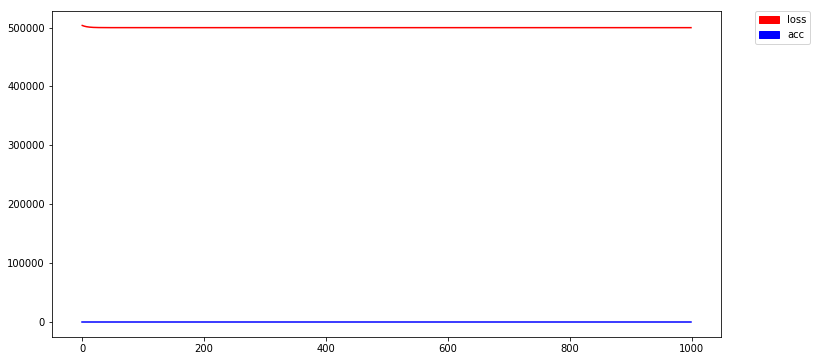

In [118]:
geo_vec_model.plot()